In [15]:
import os
import statistics
import json
import glob
from matplotlib import pyplot as plt
from posixpath import basename
import numpy as np
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
import matplotlib

In [16]:
discr_dict={'P1':0,'P2':1,'P3':2,'P4':3,'Q1':4,'Q2':5}
# mesh_dict={"square_beam_0.5":0,"square_beam_0.25":1,"square_beam_0.1":2,"square_beam_0.05":3,"square_beam_0.025":4,"square_beam_0.01":5,"square_beam_0.005":6}
# mesh_dict={"square_beam_0.025":0,"square_beam_0.022":1,"square_beam_0.021":2,"square_beam_0.020":3,"square_beam_0.019":4,"square_beam_0.016":5,"square_beam_0.013":6,"square_beam_0.01":7}
solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT"]
class Cal_result(object):
    # solver_name="AMGCL"
    # json_name="bar"
    # discr_order=1
    # n_ref=1
    # block_size=1
    # repeat_times=5
    # result_json=[]
    # time=np.zeros((1,repeat_times),dtype=np.double)
    # iter=np.zeros((1,repeat_times),dtype=np.int32)
    # err=np.zeros((1,repeat_times),dtype=np.double)
    def __init__(self,solver_name_,mesh_name_,json_name_,discr_order_,n_ref_,block_size_,repeat_times_):
        self.solver_name=solver_name_
        self.mesh_name=mesh_name_
        self.json_name=json_name_
        self.discr_order=discr_order_
        self.n_ref=n_ref_
        self.block_size=block_size_
        self.repeat_times=repeat_times_
        self.result_json=[None]*(repeat_times_+1)
        #From the json file
        self.mat_size=0
        self.nonzero=0
        self.time=np.zeros((1,repeat_times_+1),dtype=np.double)
        self.iter=np.zeros((1,repeat_times_+1),dtype=np.int32)
        self.err=np.zeros((1,repeat_times_+1),dtype=np.double)
    def avg_time(self):
        return np.average(self.time,axis=1)
    def avg_iter(self):
        return np.average(self.iter,axis=1)
    def avg_err(self):
        return np.average(self.err,axis=1)



In [17]:
def get_erriter(solver_name_,json_data_): 
    #return iter,err(0 if not exist,-1 if fail)
    if solver_name_=="AMGCL":
        return json_data_["num_iterations"],json_data_["final_res_norm"]
    if solver_name_=="Eigen::CholmodSupernodalLLT":
        if json_data_["solver_info"]=="Success":
            return 0,0
        else:
            return -1,-1
    if solver_name_=="Eigen::ConjugateGradient":
        return json_data_["solver_iter"], json_data_["solver_error"]
    if solver_name_=="Hypre":
        return json_data_["num_iterations"],json_data_["final_res_norm"]
    if solver_name_=="Eigen::PardisoLDLT":
        if json_data_["solver_info"]=="Success":
            return 0,0
        else:
            return -1,-1
    if solver_name_=="Eigen::SimplicialLDLT":
        if json_data_["solver_info"]=="Success":
            return 0,0
        else:
            return -1,-1

In [18]:
def stats(j_file_): 
    #return solving_time,iterations,error,mat_order
    with open(j_file_, 'r') as f:
        json_data = json.load(f)
    solver_name=json_data["args"]["solver_type"]
    tensor_formulation=json_data["args"]["tensor_formulation"]
    mat_size=json_data["mat_size"]
    nonzero=json_data["num_non_zero"]
    time_solving=json_data["time_solving"]
    num_iterations=0
    err=0
    solver_info=json_data["solver_info"]
    if tensor_formulation=="NeoHookean":
        err_list=[]
        iter_list=[]
        for temp in json_data["solver_info"][0]["info"]["internal_solver"]:
            tempiter,temperr=get_erriter(solver_name,temp)
            err_list.append(temperr)
            iter_list.append(tempiter)
        err=statistics.mean(err_list)
        num_iterations=sum(iter_list)
        # Need to verify the mat_order
        return time_solving,num_iterations,err,mat_size,nonzero
    else:
        tempiter,temperr=get_erriter(solver_name,solver_info)
        return time_solving,tempiter,temperr,mat_size,nonzero
    # Add "if" for more problems                

# Prepare data

In [19]:
# path_lists=[glob.glob("results/square/**/**/**/**/**/**"),glob.glob("results/square_pre/**/**/**/**/**/**")]
path_lists=[glob.glob("results/square/**/**/**/**/**/**")]
start_index=2
result_list=[]
fail_list=[]
for path_list in path_lists:
    for path in path_list:
        temp_path=path.split('/')
        solver_name=temp_path[0+start_index]
        mesh_name=temp_path[1+start_index]
        json_name=temp_path[2+start_index]
        discr_order=discr_dict[temp_path[3+start_index]]
        n_ref=int(temp_path[4+start_index][-1])
        block_size=int(temp_path[5+start_index][-1])
        repeat_path=glob.glob(os.path.join(path,"*"))
        repeat_times=max(map(int,map(os.path.basename,repeat_path)))
        temp_result=Cal_result(solver_name,mesh_name,json_name,discr_order,n_ref,block_size,repeat_times)
        exist_bool=True
        for inner_path in repeat_path:
            repeat_time=int(os.path.basename(inner_path))
            json_path=os.path.join(inner_path,"json","result.json")
            if os.path.exists(json_path):
                temp_result.time[0,repeat_time],temp_result.iter[0,repeat_time],temp_result.err[0,repeat_time],temp_result.mat_size,temp_result.nonzero=stats(json_path)
                temp_result.result_json[repeat_time]=inner_path
            else:
                fail_list.append(inner_path)
                # print(inner_path+" is empty, corresponding test failed")
                exist_bool=False
        if exist_bool:
            result_list.append(temp_result)

In [20]:
columns=["Scene","Solver","Mesh","Mat Size","Nonzeros","discr_order","n_ref","Block Size","Runtime","Error","Iterations"]
result_df=pd.DataFrame(columns=columns)
for result,i in zip(result_list,range(len(result_list))):
    df_row={}
    df_row["Scene"]=result.json_name
    df_row["Mesh"]=result.mesh_name
    df_row["Mat Size"]=result.mat_size
    df_row["Nonzeros"]=result.nonzero
    df_row["Solver"]=result.solver_name
    df_row["discr_order"]=result.discr_order
    df_row["n_ref"]=result.n_ref
    df_row["Block Size"]=result.block_size
    df_row["Runtime"]=np.average(result.time,axis=1)
    df_row["Error"]=np.average(result.err,axis=1)
    df_row["Iterations"]=np.average(result.iter,axis=1)
    result_df.loc[i]=df_row

In [41]:
def nonzero_plot(solver_name_,block_size_,ax_,df,xtick,cmap_,cindex_):
    degree=1
    tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_)& (df["discr_order"]==1)]
    tempdf=tempdf.sort_values(by=['Nonzeros'])
    xdata=np.int64(tempdf["Nonzeros"])
    ydata=np.float64(tempdf["Runtime"])
    logx = np.log(xdata)
    logy = np.log(ydata)
    coeffs = np.polyfit(logx,logy,deg=degree)
    poly = np.poly1d(coeffs)
    yfit = lambda x: np.exp(poly(np.log(x)))
    if solver_name_=="Eigen::CholmodSupernodalLLT":
        label_="Cholmod"
    elif solver_name_=="Eigen::PardisoLDLT":
        label_="Pardiso"
    else:
        label_=solver_name_+"B"+str(block_size_)
    ax_.scatter(xdata,ydata,label=label_,color=cmap_[cindex_])
    label_=label_+", k="+str("%.2f" % coeffs[degree-1])
    ax_.plot(xtick,yfit(xtick),label=label_,color=cmap_[cindex_])
    

In [39]:
def matsize_plot(solver_name_,block_size_,ax_,df,xtick,cmap_,cindex_):
    degree=1
    tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_)& (df["discr_order"]==1)]
    tempdf=tempdf.sort_values(by=['Mat Size'])
    xdata=np.int64(tempdf["Mat Size"])
    ydata=np.float64(tempdf["Runtime"])
    logx = np.log(xdata)
    logy = np.log(ydata)
    coeffs = np.polyfit(logx,logy,deg=degree)
    poly = np.poly1d(coeffs)
    yfit = lambda x: np.exp(poly(np.log(x)))
    if solver_name_=="Eigen::CholmodSupernodalLLT":
        label_="Cholmod"
    elif solver_name_=="Eigen::PardisoLDLT":
        label_="Pardiso"
    else:
        label_=solver_name_+"B"+str(block_size_)
    ax_.scatter(xdata,ydata,label=label_,color=cmap_[cindex_])
    label_=label_+", k="+str("%.2f" % coeffs[degree-1])
    ax_.plot(xtick,yfit(xtick),label=label_,color=cmap_[cindex_])

# Nonzeros

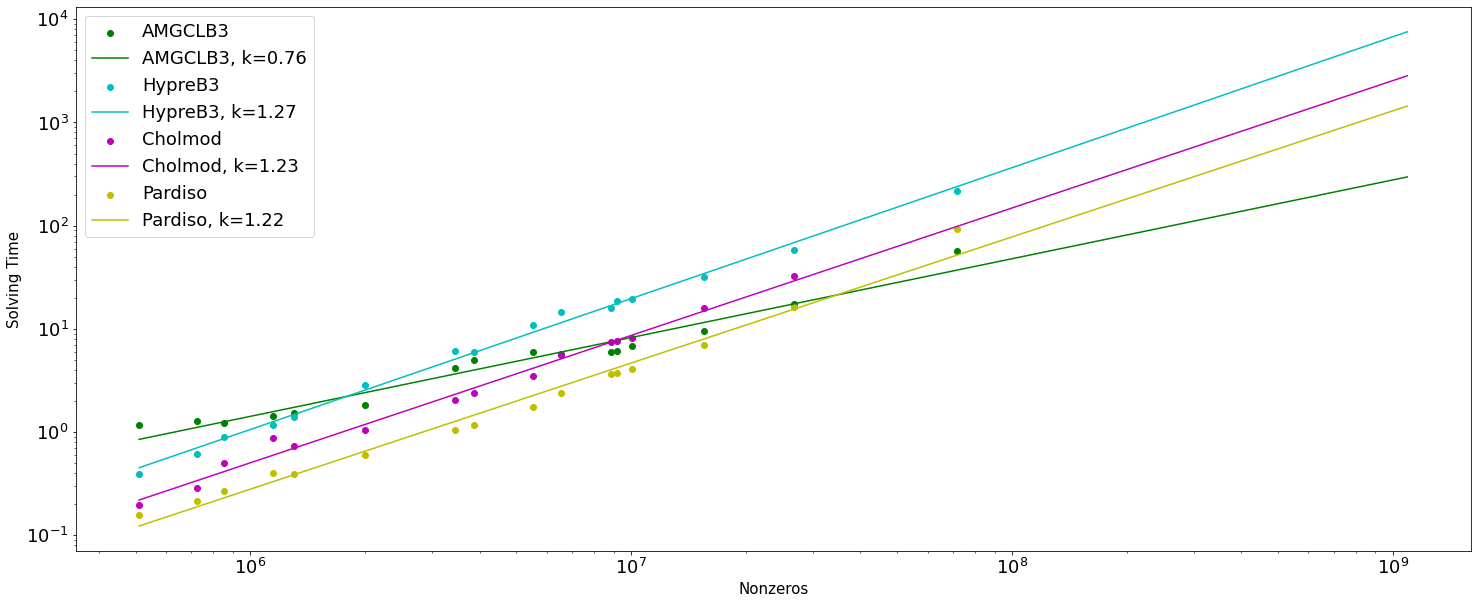

In [42]:
%matplotlib inline
solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT"]
cmap=['b','g','r','c','m','y','k','w']
nonzeros=np.sort(np.int64(result_df["Nonzeros"].unique()))
fig,ax=plt.subplots(figsize=(25,10)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
ax.set_xlabel("Nonzeros",fontsize=15) # x labels
ax.set_ylabel("Solving Time",fontsize=15) # y labels
# nonzero_plot("AMGCL",1,ax,result_df,nonzeros,cmap,0)
nonzero_plot("AMGCL",3,ax,result_df,nonzeros,cmap,1)
# nonzero_plot("Hypre",1,ax,result_df,nonzeros,cmap,2)
nonzero_plot("Hypre",3,ax,result_df,nonzeros,cmap,3)
nonzero_plot("Eigen::CholmodSupernodalLLT",1,ax,result_df,nonzeros,cmap,4)
nonzero_plot("Eigen::PardisoLDLT",1,ax,result_df,nonzeros,cmap,5)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
ax.legend()

plt.xscale("log") # log scale
plt.yscale("log") # log scale

# Mat Size

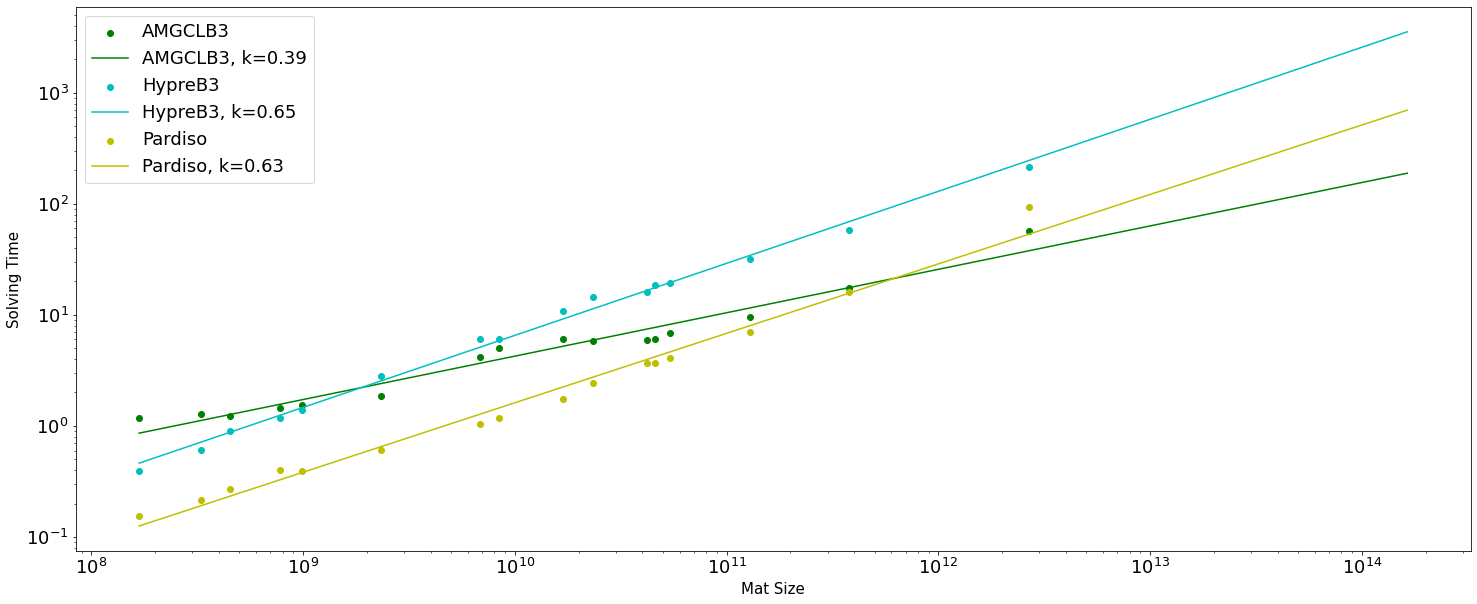

In [40]:
%matplotlib inline
solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT"]
cmap=['b','g','r','c','m','y','k','w']
matsize=np.sort(np.int64(result_df["Mat Size"].unique()))
fig,ax=plt.subplots(figsize=(25,10)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
ax.set_xlabel("Mat Size",fontsize=15) # x labels
ax.set_ylabel("Solving Time",fontsize=15) # y labels
# matsize_plot("AMGCL",1,ax,result_df,matsize,cmap,0)
matsize_plot("AMGCL",3,ax,result_df,matsize,cmap,1)
# matsize_plot("Hypre",1,ax,result_df,matsize,cmap,2)
matsize_plot("Hypre",3,ax,result_df,matsize,cmap,3)
# matsize_plot("Eigen::CholmodSupernodalLLT",1,ax,result_df,matsize,cmap,4)
matsize_plot("Eigen::PardisoLDLT",1,ax,result_df,matsize,cmap,5)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
ax.legend()

plt.xscale("log") # log scale
plt.yscale("log") # log scale

# Plot

In [7]:
def search_result(solver_name_=None,mesh_name_=None,json_name_=None,discr_order_=None,n_ref_=None,block_size_=None):
    masks=np.ones_like(np.arange(len(result_list)),dtype=bool)
    for i in np.arange(len(result_list)):
        if masks[i]==0:
            continue
        else:
            if solver_name_!=None:
                if result_list[i].solver_name!=solver_name_:
                    masks[i]=0
                    continue
            if mesh_name_!=None:
                if result_list[i].mesh_name!=mesh_name_:
                    masks[i]=0
                    continue
            if json_name_!=None:
                if result_list[i].json_name!=json_name_:
                    masks[i]=0
                    continue
            if discr_order_!=None:
                if result_list[i].discr_order!=discr_order_:
                    masks[i]=0
                    continue
            if n_ref_!=None:
                if result_list[i].n_ref!=n_ref_:
                    masks[i]=0
                    continue
            if block_size_!=None:
                if result_list[i].block_size!=block_size_:
                    masks[i]=0
                    continue
    return_list=[]
    for i in range(len(result_list)):
        if masks[i]==True:
            return_list.append(result_list[i])
    return return_list